In [1]:
%matplotlib inline

import os
import numpy as np
import glob
import random
from tqdm import tqdm
import datetime

import torch
from torch.utils import data
from torch.autograd import Variable
from torch import optim
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models

from visualize import *
from crowdnet_pytorch import CrowdNet
from hdf5_dataset import HDF5Dataset

/home/samuel_cahyawijaya/anaconda2/envs/py36/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
model_name = 'demo_dcc_crowdnet'
model_path = os.path.expanduser(os.path.join('./models', model_name))
data_path = os.path.expanduser(os.path.join('./data', model_name))

In [3]:
model = CrowdNet(True)
if torch.cuda.is_available():
    model.cuda()

In [4]:
print(model)

CrowdNet(
  (deep_network): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1), ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1), ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1), ceil_mode=Fa

In [5]:
hdf5_train_ds = HDF5Dataset(os.path.join(data_path,'train.txt'))
hdf5_train_loader = data.DataLoader(dataset=hdf5_train_ds, batch_size=32, shuffle=False)

In [6]:
hdf5_test_ds = HDF5Dataset(os.path.join(data_path,'test.txt'))
hdf5_test_loader = data.DataLoader(dataset=hdf5_test_ds, batch_size=32, shuffle=False)

(3, 225, 225)
(27, 27)
(3, 225, 225)
(27, 27)
(3, 225, 225)
(27, 27)
(3, 225, 225)
(27, 27)
(3, 225, 225)
(27, 27)
(3, 225, 225)
(27, 27)


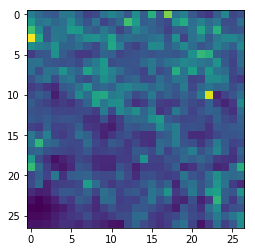

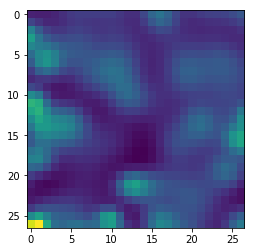

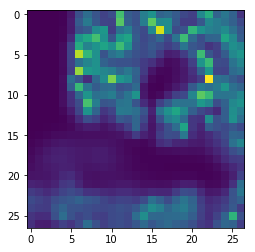

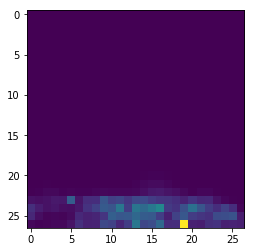

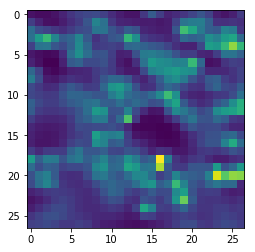

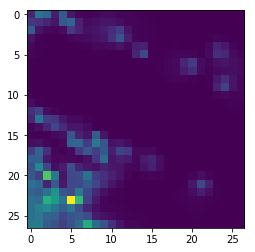

In [7]:
for i in range(3):
    X_train, Y_train = hdf5_train_ds[i]
    X_test, Y_test = hdf5_test_ds[i]
    print(X_train.shape)
    print(Y_train.shape)
    print(X_test.shape)
    print(Y_test.shape)
    
    plt.figure()
    plt.imshow(Y_train)
    plt.figure()
    plt.imshow(Y_test)

In [12]:
lr = 0.001
optimizer = optim.Adam(model.parameters(), lr=lr)
criterion = nn.MSELoss()
metric = nn.L1Loss()

In [14]:
print(datetime.date.today())
for num_iter in range(10,15):
    print("== epoch {} ==".format(num_iter+1))

    # Training Model
    pbar_train = tqdm(enumerate(hdf5_train_loader), total=len(hdf5_train_loader))
    total_loss = 0.0    
    for i, data in pbar_train:
        src_img = Variable(torch.Tensor(data[0]))
        trg_img = Variable(torch.Tensor(data[1]))

        if torch.cuda.is_available():
            src_img = src_img.cuda()
            trg_img = trg_img.cuda()

        optimizer.zero_grad() # reset optimizer
        predict_img = model(src_img)
       
        loss = criterion(predict_img, trg_img)
        loss.backward()

        optimizer.step()
        total_loss += loss.data[0]
        pbar_train.set_description('L:{:.5f}'.format(total_loss))
    print("MSE Loss : {}".format(total_loss))
        
    # Save Model
    torch.save(model.state_dict(), os.path.join(model_path,'cc_epoch_{}.mdl'.format(num_iter + 1)))

    # Evaluate Model
    pbar_test = tqdm(enumerate(hdf5_test_loader), total=len(hdf5_test_loader))
    total_mae = 0.0
    for j, data in pbar_test:
        src_img = Variable(torch.Tensor(data[0]))
        trg_img = Variable(torch.Tensor(data[1]))

        if torch.cuda.is_available():
            src_img = src_img.cuda()
            trg_img = trg_img.cuda()

        predict_img = model(src_img)
        loss = metric(predict_img, trg_img)
        total_mae += loss.data[0]

        pbar_test.set_description("MAE:{:.4f}".format(total_mae))
    print("MAE Metric : {}".format(total_mae))

print(datetime.date.today())


  0%|          | 0/273 [00:00<?, ?it/s]

2018-04-26
== epoch 11 ==



L:73.89177: 100%|██████████| 273/273 [07:32<00:00,  1.66s/it]


MSE Loss : 73.89176872372627


  0%|          | 0/273 [00:00<?, ?it/s]

MAE Metric : 4.337674289941788
== epoch 12 ==


L:44.43824: 100%|██████████| 273/273 [07:30<00:00,  1.65s/it]


MSE Loss : 44.43823602050543


  0%|          | 0/273 [00:00<?, ?it/s]

MAE Metric : 4.097705364227295
== epoch 13 ==


L:42.45377: 100%|██████████| 273/273 [07:30<00:00,  1.65s/it]


MSE Loss : 42.45377168059349


  0%|          | 0/273 [00:00<?, ?it/s]

MAE Metric : 3.961248055100441
== epoch 14 ==


L:41.30293: 100%|██████████| 273/273 [07:30<00:00,  1.65s/it]


MSE Loss : 41.30292624235153


  0%|          | 0/273 [00:00<?, ?it/s]

MAE Metric : 3.964647799730301
== epoch 15 ==


L:40.28115: 100%|██████████| 273/273 [07:30<00:00,  1.65s/it]


MSE Loss : 40.281150080263615


MAE:3.9284: 100%|██████████| 15/15 [00:08<00:00,  1.85it/s]

MAE Metric : 3.928393468260765
2018-04-26
